In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# read app_sdk/app_sdk.csv
app_sdk = pd.read_csv('app_sdk/app_sdk.csv')
app_sdk = app_sdk.loc[:, ~app_sdk.columns.str.contains('^Unnamed')]

C:\Users\Kevin\AppData\Local\Temp\ipykernel_20236\1449197697.py:2: DtypeWarning: Columns (2,3,5,8) have mixed types. Specify dtype option on import or set low_memory=False.
  app_sdk = pd.read_csv('app_sdk/app_sdk.csv')


In [3]:
df_google_first = pd.read_csv('app_sdk/google_data_first.csv', encoding='ISO-8859-1')
df_google_first = df_google_first.loc[:, ~df_google_first.columns.str.contains('^Unnamed')]

In [4]:
# join df_google_first and app_sdk on inner join with my_app_id and id
df_new = pd.merge(df_google_first, app_sdk, left_on='my_app_id', right_on='id', how='inner')

In [5]:
df_new.head(2)

,my_app_id,date_published,privacy_policy,rating_app,nb_rating,num_downloads,content_rating_app,developer,categ_app,in_app,...,domains,user_agents,uninstall_date,deactivation_date,active,id,activation_date,install_date,sdk_name,sdk_type
0,Alekseyt.Lusher,"January 24, 2015",NaN,4.3,"7,539","1,000,000+",PEGI 3 Learn More,Alekseyt,Entertainment,False,...,NaN,NaN,NaN,NaN,False,Alekseyt.Lusher,NaN,2015-01-24,Android Pay,DEV_TOOL
1,Alekseyt.Lusher,"January 24, 2015",NaN,4.3,"7,539","1,000,000+",PEGI 3 Learn More,Alekseyt,Entertainment,False,...,NaN,NaN,NaN,NaN,False,Alekseyt.Lusher,NaN,2015-01-24,Google Drive,DEV_TOOL


In [6]:
# drop id column
df_new = df_new.drop(columns=['id'])

In [7]:
def dataframe_summary(df):
    print(f"DataFrame contains {df.shape[0]} rows and {df.shape[1]} columns.\n")
    df_info = pd.DataFrame({
        'Data Type': df.dtypes,
        'Non-null Count': df.count(),
        'Null Count': df.isnull().sum(),
        'Null Percentage (%)': (df.isnull().sum() / len(df)) * 100
    })
    print(df_info)

# Run the function to get an enhanced summary of the DataFrame
dataframe_summary(df_new)

DataFrame contains 8422551 rows and 37 columns.

                    Data Type  Non-null Count  Null Count  Null Percentage (%)
my_app_id              object         8422551           0             0.000000
date_published         object         8422551           0             0.000000
privacy_policy         object         6076042     2346509            27.859837
rating_app            float64         8053783      368768             4.378341
nb_rating              object         8053783      368768             4.378341
num_downloads          object         8422371         180             0.002137
content_rating_app     object         8422551           0             0.000000
developer              object         8422550           1             0.000012
categ_app              object         8422550           1             0.000012
in_app                   bool         8422551           0             0.000000
has_ads                  bool         8422551           0             0.000000
pri

In [8]:
# drop whats_new column, privacy_policy, domains, user_agents, uninstall_date, deactivation_date, activation_date
df_new = df_new.drop(columns=['whats_new', 'privacy_policy', 'domains', 'user_agents', 'uninstall_date', 'deactivation_date', 'activation_date'])

In [9]:
dataframe_summary(df_new)

DataFrame contains 8422551 rows and 30 columns.

                    Data Type  Non-null Count  Null Count  Null Percentage (%)
my_app_id              object         8422551           0             0.000000
date_published         object         8422551           0             0.000000
rating_app            float64         8053783      368768             4.378341
nb_rating              object         8053783      368768             4.378341
num_downloads          object         8422371         180             0.002137
content_rating_app     object         8422551           0             0.000000
developer              object         8422550           1             0.000012
categ_app              object         8422550           1             0.000012
in_app                   bool         8422551           0             0.000000
has_ads                  bool         8422551           0             0.000000
price_gplay            object         8033359      389192             4.620833
ope

In [10]:
# 
df_new['in_app_product'].unique()

array([nan, '£1.00 per item', '£0.99 - £2.89 per item', ...,
       '£6.49 - £38.49 per item', '£0.89 - £39.49 per item',
       '£0.60 - £36.27 per item'], dtype=object)

In [11]:
df_new.head(1)

,my_app_id,date_published,rating_app,nb_rating,num_downloads,content_rating_app,developer,categ_app,in_app,has_ads,...,similar_apps_top15,visit_website,more_from_developer,family_library,permissions,present,active,install_date,sdk_name,sdk_type
0,Alekseyt.Lusher,"January 24, 2015",4.3,"7,539","1,000,000+",PEGI 3 Learn More,Alekseyt,Entertainment,False,True,...,"com.stakan4ik.root.stakan4ik_android, ua.igra_...",http://android_lusher_test.reformal.ru/,"com.Alekseyt.TronNet, alekseyt.islandlive, com...",False,"view network connections, full network acces...",True,False,2015-01-24,Android Pay,DEV_TOOL


In [12]:
# remove email_to, permissions, family_library
df_new = df_new.drop(columns=['email_to', 'permissions', 'family_library'])

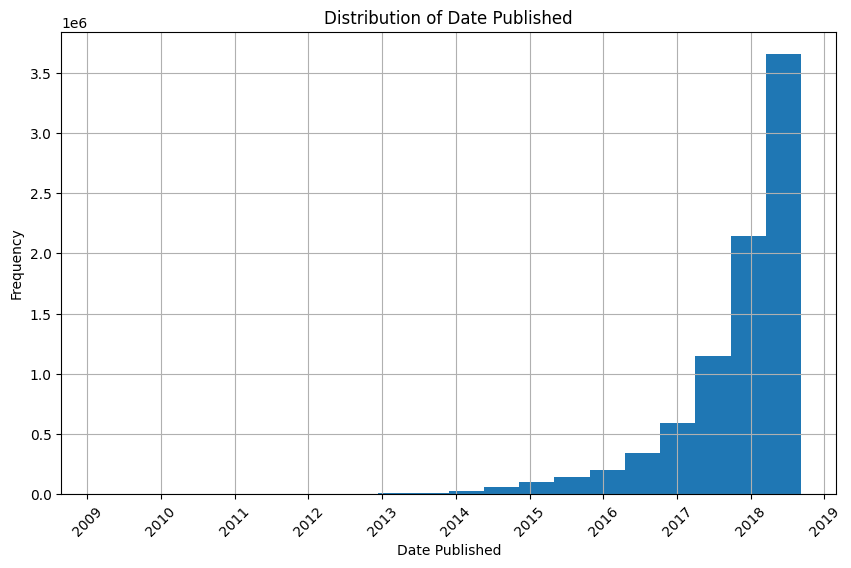

In [13]:
# histogram when apps are published
df_new['date_published'] = pd.to_datetime(df_new['date_published'])

# Plot histogram
df_new['date_published'].hist(bins=20, figsize=(10, 6))
plt.xlabel('Date Published')
plt.ylabel('Frequency')
plt.title('Distribution of Date Published')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

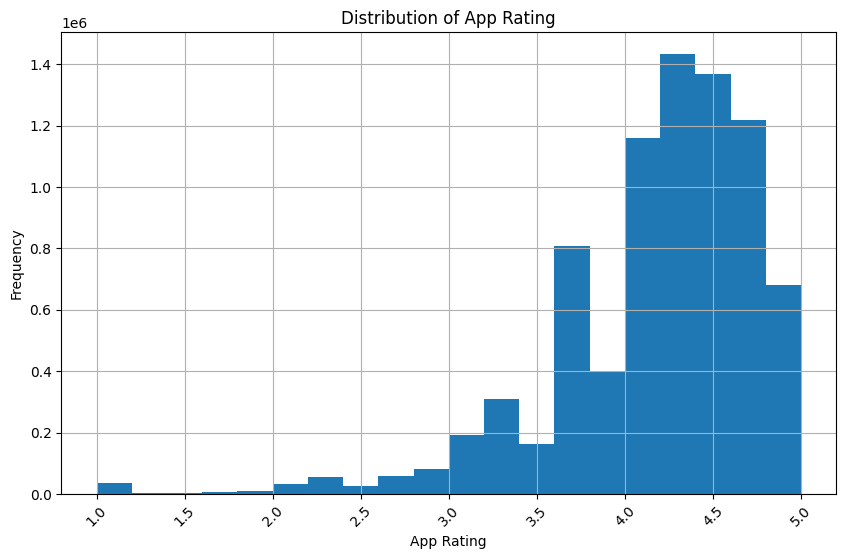

In [14]:
# Plot histogram
df_new['rating_app'].hist(bins=20, figsize=(10, 6))
plt.xlabel('App Rating')
plt.ylabel('Frequency')
plt.title('Distribution of App Rating')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [15]:
# convert 76,545 to 76545
df_new['nb_rating'] = df_new['nb_rating'].str.replace(',', '')

df_new['nb_rating'] = pd.to_numeric(df_new['nb_rating'])
df_new['rating_app'] = pd.to_numeric(df_new['rating_app'])

# Calculate the global average rating across all apps
global_mean_rating = df_new['rating_app'].mean()

# Define a prior weight (m)
# This is the number of ratings at which the average rating is considered reliable.
# Adjust based on your data; higher values give more weight to the global mean.
m = 50

# Calculate Bayesian average for each app
df_new['bayesian_average'] = (global_mean_rating * m + df_new['rating_app'] * df_new['nb_rating']) / (m + df_new['nb_rating'])


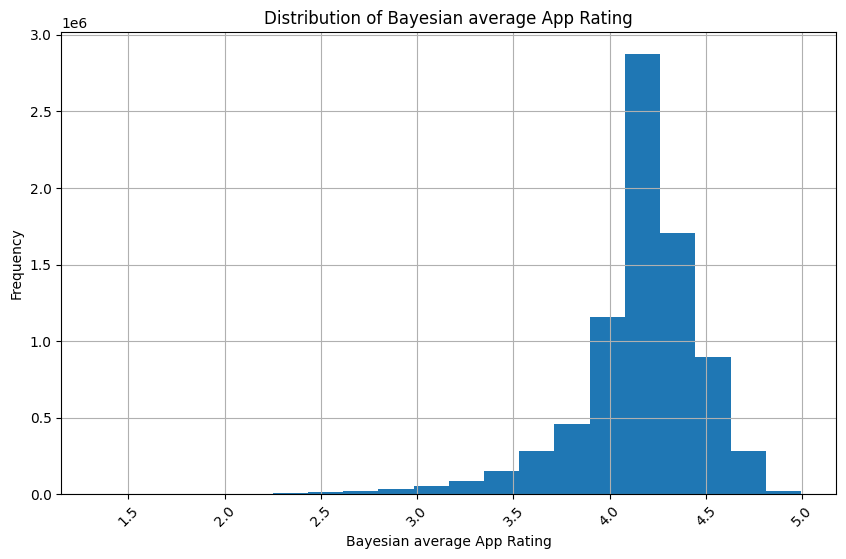

In [16]:
# Plot histogram
df_new['bayesian_average'].hist(bins=20, figsize=(10, 6))
plt.xlabel('Bayesian average App Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Bayesian average App Rating')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [17]:
# which app has the most downloads
# remove nan values
df_new = df_new.dropna(subset=['num_downloads'])

In [18]:
# Function to clean and convert to numbers
def convert_to_numeric(value):
    if pd.isna(value):
        return np.nan
    else:
        # Remove ',' and '+' and '>' and strip any whitespace
        cleaned_value = value.replace(',', '').replace('+', '').replace('>', '').strip()
        return int(cleaned_value)

# Apply the function to the DataFrame column
df_new['num_downloads'] = df_new['num_downloads'].apply(convert_to_numeric)

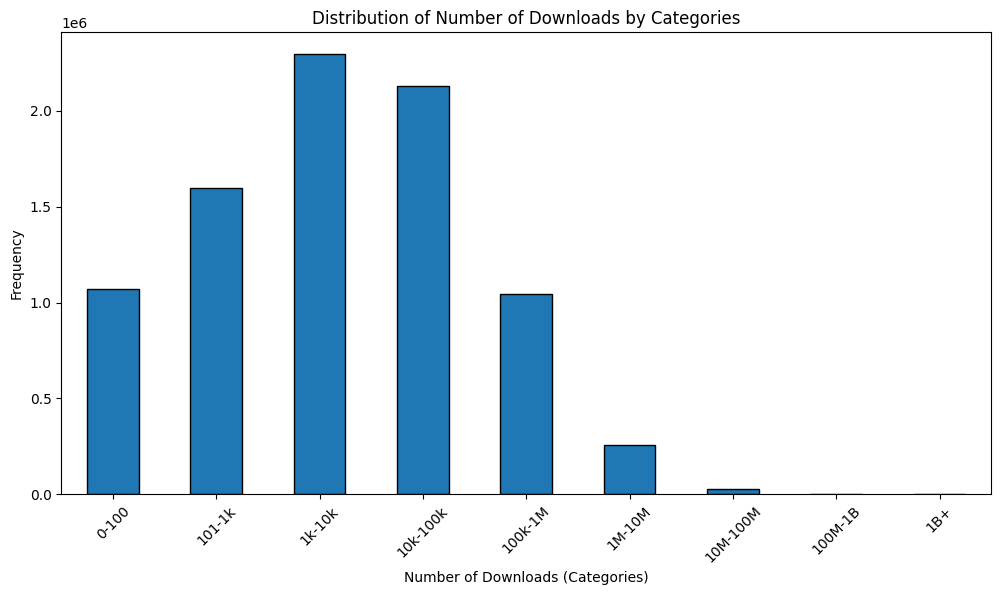

In [19]:
# Define the bins for categorization
bins = [0, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000, np.inf]
labels = ['0-100', '101-1k', '1k-10k', '10k-100k', '100k-1M', '1M-10M', '10M-100M', '100M-1B', '1B+']

# Categorize num_downloads into these bins
df_new['downloads_category'] = pd.cut(df_new['num_downloads'], bins=bins, labels=labels)

# Plot the distribution of num_downloads categories
plt.figure(figsize=(12, 6))
df_new['downloads_category'].value_counts(sort=False).plot(kind='bar', edgecolor='black')
plt.xlabel('Number of Downloads (Categories)')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Downloads by Categories')
plt.xticks(rotation=45)
plt.show()

In [20]:
# # Create a new DataFrame with only the relevant columns for correlation analysis
# correlation_data = df_new[['rating_app', 'in_app', 'has_ads', 'num_downloads']]

# # Plot pairplot to visualize correlations
# plt.figure(figsize=(10, 6))
# sns.pairplot(correlation_data, kind='reg', diag_kind='kde')
# plt.show()

In [21]:

df_new['categ_app'].unique()

array(['Entertainment', 'Tools', 'Books & Reference', 'Puzzle', 'Sports',
       'News & Magazines', 'Finance', 'Productivity', 'Education',
       'Medical', 'Maps & Navigation', 'Communication', 'Music & Audio',
       'Business', 'Lifestyle', 'Shopping', 'Auto & Vehicles', 'Card',
       'Casual', 'Travel & Local', 'Action', 'Weather', 'Arcade',
       'Video Players & Editors', 'Board', 'Personalization', 'Comics',
       'Libraries & Demo', 'Health & Fitness', 'Food & Drink',
       'Photography', 'House & Home', 'Strategy', 'Social', 'Trivia',
       'Music & Video', 'Art & Design', 'Creativity', 'Simulation',
       'Word', 'Racing', 'Events', 'Parenting', 'Music', 'Adventure',
       'Brain Games', 'Action & Adventure', 'Dating', 'Pretend Play',
       'Beauty', 'Casino', 'Educational', 'Role Playing', nan],
      dtype=object)